# Check outputs of MODIS_HRRR processing 
*J. Michelle Hu  
University of Utah  
August 2024*  
---

In [1]:
import os
import sys
import xarray as xr
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# Set environmental variable for PROJ to directory where you can find proj.db
os.environ['PROJ']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'
os.environ['PROJLIB']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'

## Directory

In [4]:
# basin = 'blue_river'
basin = 'yampa'

In [5]:
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/'
basindirs = h.fn_list(workdir, f'*{basin}*')
basindirs

['/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/yampa_100m_isnobal',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/yampa_100m_isnobal_solar_albedo']

In [6]:
# Get the WY from the directory name
WY = int(h.fn_list(basindirs[0], '*')[0].split('/')[-1].split('wy')[-1])
WY

2020

## Specify a point for evaluation

In [7]:
snotel_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL'

In [ ]:
# TODO: add data to locate snotel within basin
# Basin polygon file
# Locate SNOTEL sites within basin
# Get site names and site numbers

In [9]:
# Pull a point
# sitenum = '485' # Fremont pass
sitenum = '709' # Rabbit Ears
snotelfn = h.fn_list(snotel_dir, f'*{sitenum}*csv')[0]
df = pd.read_csv(snotelfn, skiprows=63, usecols=list(np.arange(0, 7)), parse_dates=["Date"])
# Copy date to new date indexing column
df['DateIndex'] = df['Date']

# reset index as Date
df = df.set_index('DateIndex')

# Clip to this water year
snotel_df = df[(df['Date']>=f'{int(WY) - 1}-10-01') & (df['Date']<f'{WY}-10-01')]
snotel_df.head()

,Date,Rabbit Ears (709) Snow Depth (cm) End of Day Values,Rabbit Ears (709) Snow Water Equivalent (mm) End of Day Values,Rabbit Ears (709) Snow Density (pct) End of Day Values,Rabbit Ears (709) Wind Speed Average (km/hr),Rabbit Ears (709) Air Temperature Observed (degC) End of Day Values,Rabbit Ears (709) Precipitation Increment (mm)
DateIndex,,,,,,,
2019-10-01,2019-10-01,0.0,0.0,NaN,NaN,4.4,0.0
2019-10-02,2019-10-02,0.0,0.0,NaN,NaN,0.8,0.0
2019-10-03,2019-10-03,0.0,0.0,NaN,NaN,11.1,0.0
2019-10-04,2019-10-04,0.0,0.0,NaN,NaN,-1.6,0.0
2019-10-05,2019-10-05,0.0,0.0,NaN,NaN,1.1,0.0


### Get SNOTEL coordinates

In [11]:
# Extract snotel point coords and plot
sitenums = [int(sitenum)] #[485, 531, 415, 505] # Fremont Pass, Hoosier Pass, Copper Mountain, Grizzly Peak
allsites_fn = h.fn_list(snotel_dir, '*active*csv')[0]
sites_df = pd.read_csv(allsites_fn, index_col=0)

# Extract the lats and lons based on these site numbers
snotellats = []
snotellons = []

for sitenum in sitenums:
    print(sitenum)
    this_site = sites_df[sites_df['site_num']==sitenum]
    lat, lon = this_site['lat'].values[0], this_site['lon'].values[0]
    snotellats.append(lat)
    snotellons.append(lon)

# snotellats, snotellons

# Convert to UTM EPSG 32613

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import pyproj

pyproj.datadir.set_data_dir('/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj')

# Create a Geoseries based off of a list of a Shapely point using the lat and lon from the SNOTEL site
s = gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(snotellons, snotellats)])

# Turn this into a geodataframe and specify the geom as the geoseries of the SNOTEL point
gdf = gpd.GeoDataFrame(geometry=s)

# Set the CRS inplace
gdf.set_crs('epsg:4326', inplace=True)

# Convert snotel coords' lat lon to UTM
gdf = gdf.to_crs('epsg:32613')
gdf

709


,geometry
0,POINT (352275.167 4470278.067)


In [12]:
# Get sitename
sitename = snotel_df.columns[1].split(f' Snow Depth')[0]
sitename

'Rabbit Ears (709)'

In [13]:
linestyle = '-' #':'
linewidth = 0.5
marker = None
color = 'k'
snotelcolors = ['dodgerblue', 'gray']

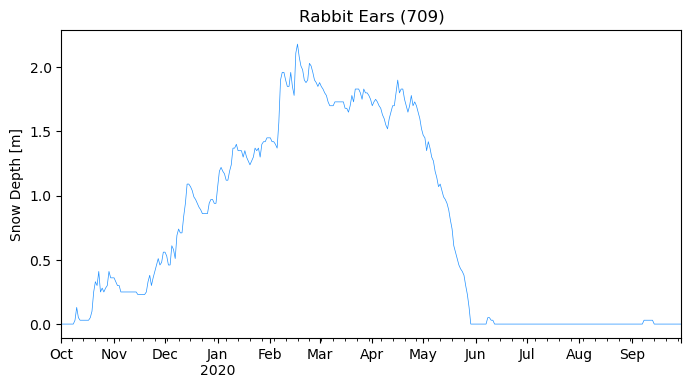

In [17]:
figsize = (8,4)
fig, ax = plt.subplots (1, figsize=figsize)
(snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100).plot(ax=ax, 
                                                                label=f'{sitename} Snow Depth [m]', 
                                                                linestyle=linestyle, 
                                                                linewidth=linewidth, 
                                                                color=snotelcolors[0], 
                                                                marker=marker
                                                                )

plt.title(sitename);
plt.xlabel(''); 
plt.ylabel('Snow Depth [m]');

# Check MODIS HRRR outputs on their own

## Check out net_solar

In [18]:
basindirs

['/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/yampa_100m_isnobal',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/yampa_100m_isnobal_solar_albedo']

In [19]:
%%time
# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
month = 'run20'
days = h.fn_list(basindirs[0], f"*/*/{month}*/smrf_energy_balance*.nc")
days = [days, h.fn_list(basindirs[1], f"__*/*/{month}*/net_solar.nc")]

# Read in datasets
isnobal_hrrr_list = [xr.open_dataset(day_fn) for day_fn in days[0]]
modis_hrrr_list = [xr.open_dataset(day_fn) for day_fn in days[1]]

print(len(days))

2
CPU times: user 10.8 s, sys: 11.8 s, total: 22.6 s
Wall time: 1min 42s


In [20]:
print(len(days[1]))

366


In [21]:
# Pull net_solar
thisvar = 'net_solar'
var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in isnobal_hrrr_list]
updated_var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in modis_hrrr_list]

# Concatenate all the days
var_data = xr.concat(var_data, dim='time')
updated_var_data = xr.concat(updated_var_data, dim='time')


In [22]:
figsize = (18, 4)
linestyles = ['-', '--']
linewidth = 1
marker = None
color = 'k'
snotelcolors = ['dodgerblue', 'gray']
isnobalcolors = ['k', 'coral']

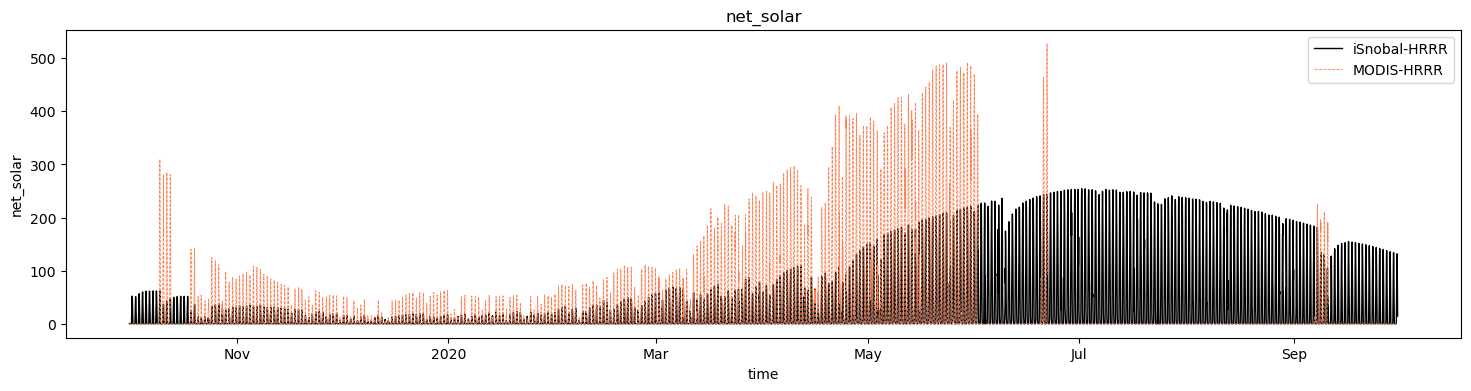

In [23]:
fig, ax = plt.subplots(1, figsize=figsize)
var_data.plot(ax=ax, 
            #   linestyle=linestyles[0], 
              color=isnobalcolors[0], label='iSnobal-HRRR', linewidth=1) 
updated_var_data.plot(ax=ax, linestyle=linestyles[1], color=isnobalcolors[1], label='MODIS-HRRR', linewidth=0.6)

plt.legend()
plt.title(thisvar);

## Check out cloud factor

In [26]:
# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
month = 'run20'
days = h.fn_list(basindirs[0], f"*/*/{month}*/cloud_factor.nc")
days = [days, h.fn_list(basindirs[1], f"__*/*/{month}*/cloud_factor.nc")]
len(days)

2

In [28]:
%%time
cloud_list = [xr.open_dataset(day_fn) for day_fn in days[0]]
tcdc_list = [xr.open_dataset(day_fn) for day_fn in days[1]]

CPU times: user 6.95 s, sys: 2.6 s, total: 9.55 s
Wall time: 22.9 s


In [29]:
%%time
thisvar = 'Cloud Factor'
var_data = [ds['cloud_factor'].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in cloud_list]
updated_var_data = [ds['TCDC'].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in tcdc_list]

# Concatenate all the days
var_data = xr.concat(var_data, dim='time')
updated_var_data = xr.concat(updated_var_data, dim='time')

CPU times: user 2min 20s, sys: 1min 25s, total: 3min 45s
Wall time: 6min 53s


Text(0.5, 1.0, 'Cloud Factor MODIS-HRRR - iSnobal-HRRR')

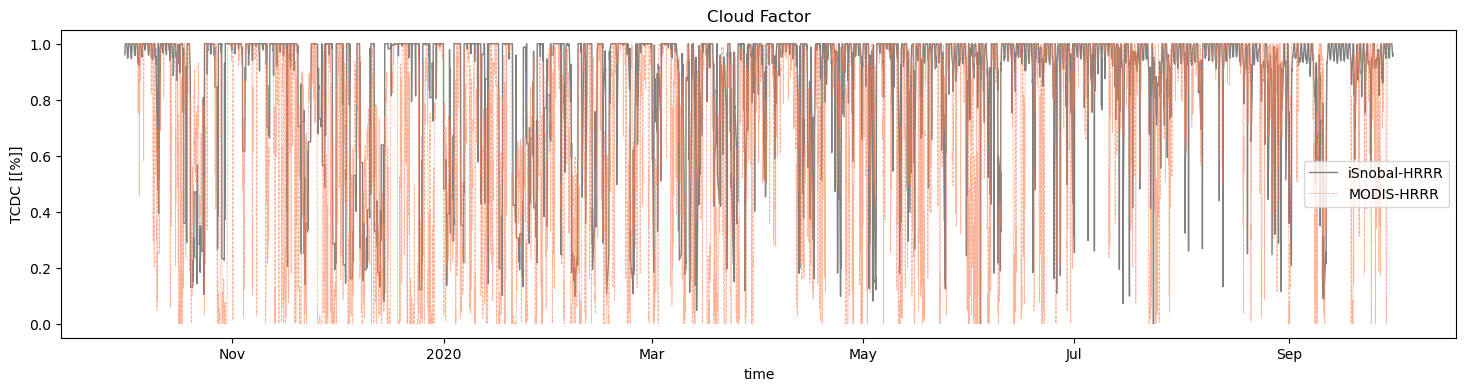

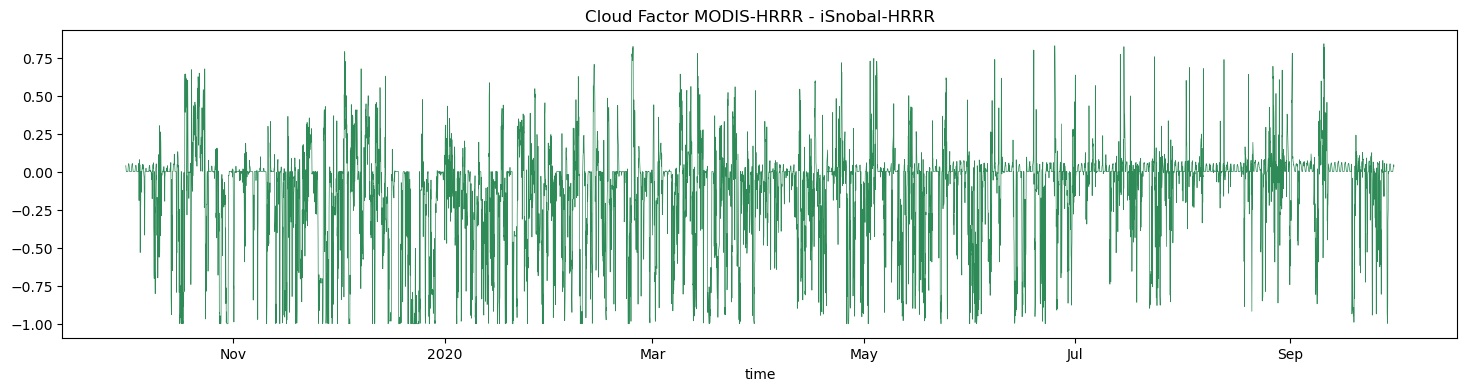

In [30]:
fig, ax = plt.subplots(1, figsize=figsize)
var_data.plot(ax=ax, 
            #   linestyle=linestyles[0], 
              color='gray', label='iSnobal-HRRR', linewidth=1) 
updated_var_data.plot(ax=ax, linestyle=linestyles[1], color=isnobalcolors[1], label='MODIS-HRRR', linewidth=0.6, alpha=0.6
                      )
plt.legend()
plt.title(thisvar)

(updated_var_data - var_data).plot(figsize=figsize, color='seagreen', linewidth=0.5)
plt.title(f'{thisvar} MODIS-HRRR - iSnobal-HRRR')

# Check state values now

## Snow depth

In [31]:
# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
month = 'run20'
days = h.fn_list(basindirs[0], f"*/*/{month}*/snow.nc")
days = [days, h.fn_list(basindirs[1], f"__*/*/{month}*/snow.nc")]
len(days)

2

In [32]:
%%time
ds_list = [xr.open_dataset(day_fn) for day_fn in days[0]]
ds_sol_list = [xr.open_dataset(day_fn) for day_fn in days[1]]

thisvar = 'thickness'
var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_list]
updated_var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_sol_list]

# Concatenate all the days
var_data = xr.concat(var_data, dim='time')
updated_var_data = xr.concat(updated_var_data, dim='time')

CPU times: user 21.3 s, sys: 11.9 s, total: 33.2 s
Wall time: 1min 38s


In [239]:
# Get disappearance dates
import processing as proc

snow_name = 'Snow Depth'
verbose = False
day_thresh = 15

snotel_sdd, _ = proc.calc_sdd(snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100, 
                              snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
print(snotel_sdd)
# Convert model data to Pandas Series
classic_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(var_data.data), index=var_data.time.values),
                              snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
print(classic_sdd)

# Convert model data to Pandas Series
modis_hrrr_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(updated_var_data.data), index=updated_var_data.time.values),
                              snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
print(modis_hrrr_sdd)

2020-05-29 00:00:00
2020-06-26 22:00:00
2020-08-24 22:00:00


CPU times: user 35.5 ms, sys: 1.88 ms, total: 37.4 ms
Wall time: 36.2 ms


Text(2020-08-24 22:00:00, 2.5, '2020-08-24')

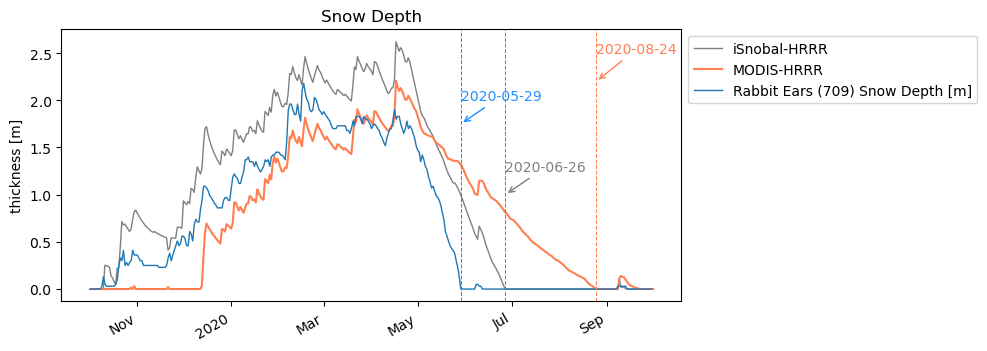

In [246]:
%%time
figsize = (8, 4)
fig, ax = plt.subplots(1, figsize=figsize)
var_data.plot(ax=ax, color='gray', label='iSnobal-HRRR', linewidth=1)
updated_var_data.plot(ax=ax, color=isnobalcolors[1], label='MODIS-HRRR')

# Plot WY time series of snow depth
(snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100).plot(ax=ax, 
                                                                label=f'{sitename} Snow Depth [m]', 
                                                                linestyle=linestyle, 
                                                                linewidth=linewidth, 
                                                                # color=snotelcolors[0], 
                                                                marker=marker)

# plt.legend(bbox_to_anchor=(1,-0.2), ncol=3, alignment='center')
plt.legend(bbox_to_anchor=(1,1), alignment='center')
plt.title('Snow Depth')
plt.xlabel('')

# Add callouts of disappearance dates with vertical lines
plt.axvline(snotel_sdd, color=snotelcolors[0], linestyle='--', linewidth=0.75, label='SNOTEL SDD')
plt.axvline(classic_sdd, color='gray', linestyle='--', linewidth=0.75, label='iSnobal-HRRR SDD')
plt.axvline(modis_hrrr_sdd, color='coral', linestyle='--', linewidth=0.75, label='MODIS-HRRR SDD')

# Add arrows pointing left towards the vertical lines above, in the same color as the line
plt.annotate(f'{snotel_sdd.strftime("%Y-%m-%d")}', xy=(snotel_sdd, 1.75), xytext=(snotel_sdd, 2),
             color=snotelcolors[0], arrowprops=dict(color=snotelcolors[0], arrowstyle='->'))
plt.annotate(f'{classic_sdd.strftime("%Y-%m-%d")}', xy=(classic_sdd, 1), xytext=(classic_sdd, 1.25),
             color='gray', arrowprops=dict(color='gray', arrowstyle='->'))
plt.annotate(f'{modis_hrrr_sdd.strftime("%Y-%m-%d")}', xy=(modis_hrrr_sdd, 2.2), xytext=(modis_hrrr_sdd, 2.5),
             color='coral', arrowprops=dict(color='coral', arrowstyle='->'))